In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prefix path
prefix = '/content/drive/MyDrive/데이터크리에이터캠프/CV/task2/jinwoo'

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [4]:
# tup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.95.2.234:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.95.2.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.2.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [5]:
# dataset 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [6]:
# class 수
num_class = len(np.unique(y_train))

In [7]:
# valid dataset 생성
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, random_state=42)

In [8]:
# one-hot encoding
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

In [9]:
# data shape
x_train.shape, x_val.shape, x_test.shape

((37500, 32, 32, 3), (12500, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
# 전처리 함수
# normalizing
def normalizing(x_batch, y_batch):
  x_batch = tf.cast(x_batch, tf.float32)
  x_batch /= 255.0

  return x_batch, y_batch


def resizing(x_batch, y_batch):
  x_batch = tf.image.resize(x_batch, (71, 71))

  return x_batch, y_batch

In [11]:
# 데이터 셋 생성
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(normalizing).shuffle(1000, seed=42)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
valid_dataset = valid_dataset.batch(batch_size).map(normalizing)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size).map(normalizing)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
with strategy.scope():
  # model
  model = keras.models.Sequential([
              keras.layers.Conv2D(16, 5, activation='relu', input_shape=(32, 32, 3)),
              keras.layers.BatchNormalization(),
              keras.layers.MaxPool2D(pool_size=(3, 3)),
              keras.layers.Conv2D(32, 3, activation='relu'),
              keras.layers.BatchNormalization(),
              keras.layers.MaxPool2D(pool_size=(2, 2)),
              keras.layers.Flatten(),
              keras.layers.Dense(120, activation='relu'),
              keras.layers.BatchNormalization(),
              keras.layers.Dense(62, activation='relu'),
              keras.layers.BatchNormalization(),
              keras.layers.Dense(20, activation='relu'),
              keras.layers.Dense(num_class, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
  )

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0

In [19]:
# callback method

# checkpoint path
ckpt_name = 'CNN_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# 디렉토리가 존재하지 않으면 생성
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # accuracy 기준 가장 높은 모델의 weight 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        verbose=1, 
        patience=10
    )
]

In [20]:
hist = model.fit(train_dataset, validation_data=valid_dataset, callbacks=callbacks_list, epochs=100)

Epoch 1/100
74/74 [==============================] - 2s 32ms/step - loss: 1.3818 - accuracy: 0.5067 - val_loss: 2.4223 - val_accuracy: 0.1726
Epoch 2/100
74/74 [==============================] - 2s 31ms/step - loss: 1.2894 - accuracy: 0.5410 - val_loss: 2.1466 - val_accuracy: 0.2578
Epoch 3/100
74/74 [==============================] - 2s 30ms/step - loss: 1.2185 - accuracy: 0.5683 - val_loss: 1.7436 - val_accuracy: 0.3765
Epoch 4/100
74/74 [==============================] - 2s 31ms/step - loss: 1.1510 - accuracy: 0.5919 - val_loss: 1.7327 - val_accuracy: 0.3986
Epoch 5/100
74/74 [==============================] - 2s 31ms/step - loss: 1.0946 - accuracy: 0.6138 - val_loss: 1.4629 - val_accuracy: 0.5046
Epoch 6/100
74/74 [==============================] - 3s 35ms/step - loss: 1.0487 - accuracy: 0.6316 - val_loss: 1.2808 - val_accuracy: 0.5468
Epoch 7/100
74/74 [==============================] - 2s 31ms/step - loss: 0.9971 - accuracy: 0.6506 - val_loss: 1.2801 - val_accuracy: 0.5496
Epoch 

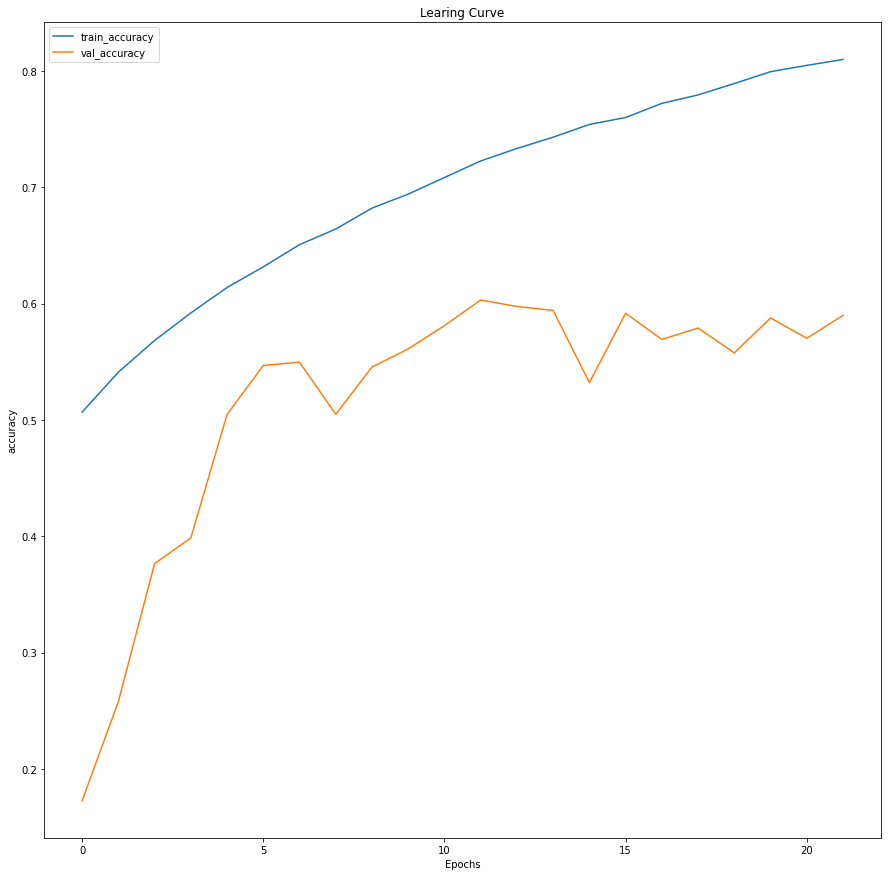

In [26]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [22]:
# load last ckpt weight
model.load_weights(checkpoint_path)

In [23]:
# evaluate test set
model.evaluate(test_dataset)

20/20 [==============================] - 1s 12ms/step - loss: 1.1795 - accuracy: 0.6058


[1.179497480392456, 0.6057999730110168]

In [27]:
with strategy.scope():
  # Xception
  base = keras.applications.Xception(input_shape=(71, 71, 3), weights=None, include_top=False)

  # make top
  xception = keras.models.Sequential()
  xception.add(base)
  xception.add(keras.layers.GlobalAveragePooling2D())
  xception.add(keras.layers.Dense(num_class, activation='softmax'))

  xception.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
  )

In [28]:
# 데이터 셋 생성
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(normalizing).map(resizing).shuffle(1000, seed=42)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
valid_dataset = valid_dataset.batch(batch_size).map(normalizing).map(resizing)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size).map(normalizing).map(resizing)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [29]:
xception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,827,442
Non-trainable params: 54,528
_________________________________________________________________


In [30]:
# callback method

# checkpoint path
ckpt_name = 'xception_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# 디렉토리가 존재하지 않으면 생성
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # accuracy 기준 가장 높은 모델의 weight 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        verbose=1, 
        patience=10
    )
]

In [31]:
hist = xception.fit(train_dataset, validation_data=valid_dataset, callbacks=callbacks_list, epochs=100)

Epoch 1/100
74/74 [==============================] - 85s 550ms/step - loss: 1.3368 - accuracy: 0.5141 - val_loss: 2.3048 - val_accuracy: 0.1000
Epoch 2/100
74/74 [==============================] - 6s 80ms/step - loss: 0.8689 - accuracy: 0.6897 - val_loss: 2.3128 - val_accuracy: 0.1000
Epoch 3/100
74/74 [==============================] - 6s 81ms/step - loss: 0.6133 - accuracy: 0.7844 - val_loss: 2.3398 - val_accuracy: 0.1000
Epoch 4/100
74/74 [==============================] - 6s 79ms/step - loss: 0.4520 - accuracy: 0.8399 - val_loss: 2.4159 - val_accuracy: 0.1000
Epoch 5/100
74/74 [==============================] - 6s 79ms/step - loss: 0.2969 - accuracy: 0.8973 - val_loss: 2.5882 - val_accuracy: 0.1000
Epoch 6/100
74/74 [==============================] - 6s 80ms/step - loss: 0.2090 - accuracy: 0.9272 - val_loss: 2.9030 - val_accuracy: 0.1106
Epoch 7/100
74/74 [==============================] - 6s 80ms/step - loss: 0.1639 - accuracy: 0.9421 - val_loss: 2.5564 - val_accuracy: 0.2499
Epoc

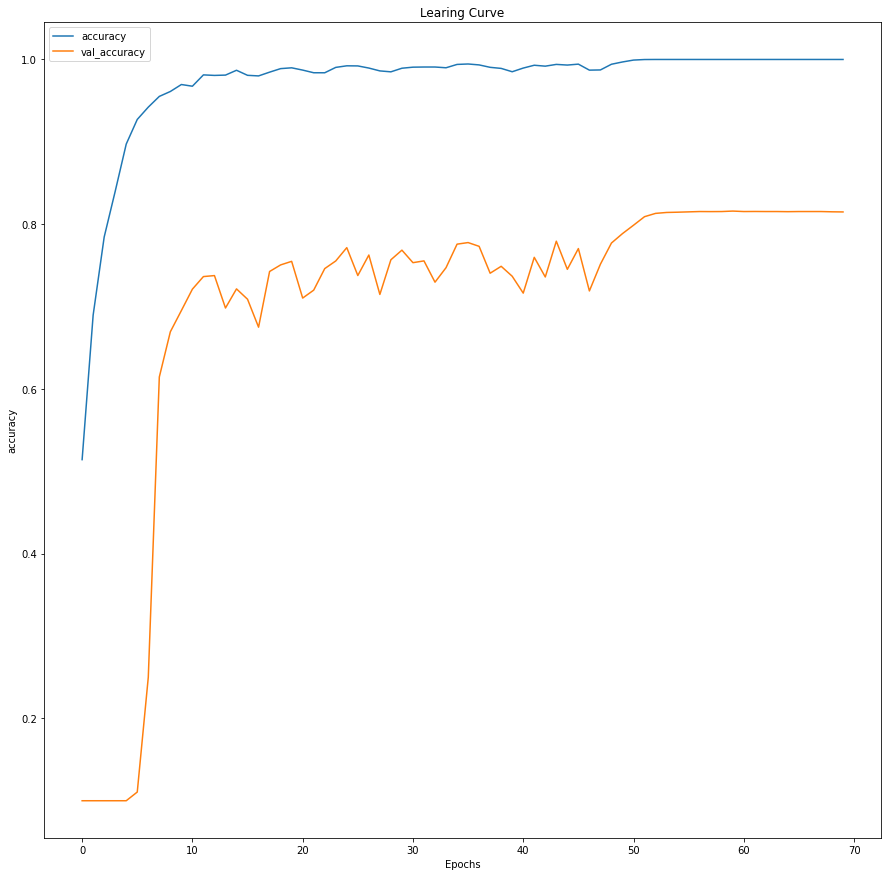

In [36]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [33]:
# load last ckpt weight
xception.load_weights(checkpoint_path)

In [34]:
# evaluate test set
xception.evaluate(test_dataset)

20/20 [==============================] - 6s 257ms/step - loss: 1.2486 - accuracy: 0.8115


[1.2485828399658203, 0.8114999532699585]